In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

from sklearn.preprocessing import LabelEncoder # преобразование категориальных пеерменных

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #метрики классификации
from sklearn.metrics import roc_auc_score # площадь под кривой ошибок

from sklearn.preprocessing import StandardScaler #стандартизатор

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

Так как работа над проектом производится с нескольких устройств, то сделаю так, чтобы файл подтягивался со стороннего ресурса:

In [2]:
from io import BytesIO
import requests
spreadsheet_id = '1cNojMY5TX5Lw1yxxnOFUmKnmn7SamqGqzO2-aL_JSgc'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
bank = pd.read_csv(BytesIO(r.content))  

https://disk.yandex.ru/i/UePygqqo37BSNw ссылка на презентацию исследования

# Тема: Сегментация пользователей по потреблению продуктов банка.

## Обзор и предобработка данных

### Обзор данных

1) выведение информации о датасете

2) поиск дубликатов

3) поиск пропущенных значений

In [3]:
bank.head() #ознакомимся с датафреймом

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [4]:
bank.info() #посмотрим информацию о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [5]:
shape = bank.shape
print(f'Количество строк  - {shape[0]}, количество столбцов  - {shape[1]}')

Количество строк  - 10000, количество столбцов  - 12


In [6]:
bank.isna().sum() #проверим датасет на пропуски

userid                 0
score                  0
City                   0
Gender                 0
Age                    0
Objects                0
Balance             3617
Products               0
CreditCard             0
Loyalty                0
estimated_salary       0
Churn                  0
dtype: int64

In [7]:
bank.duplicated().sum() #проверим датасет на явные дубликаты

0

Для удобного и правильного анализа данных сделаем следующие моменты:

1) Приведем название столбцов к нижнему и змеиному регистру;

2) Проанализируем и если будет нужно заполним пропуски;

3) Переведем нечисловые значения признаков в числовые.

### Предобработка данных

#### Обработка типов данных (перевод нечисловых признаков в числовые)

In [8]:
bank.columns = bank.columns.str.lower() #приведем название столбцов к нижнему регистру

In [9]:
bank_original = bank.copy() #сохраним оригинальный датасет 

In [10]:
# преобразуем категориальные переменные столбца gender Ж = 0, М = 1.
encoder = LabelEncoder()
encoder.fit(bank['gender'])
bank['gender_new'] = encoder.transform(bank['gender']) 

In [11]:
bank = pd.get_dummies(bank.drop(['gender'], axis = 1)) #преобразуем города

#### Изменение наименования колонок

In [12]:
bank = bank.rename(columns = {'userid': 'user_id',
                             'creditcard': 'credit_card',
                             'city_Ростов Великий': 'Ростов Великий',
                             'city_Рыбинск': 'Рыбинск',
                             'city_Ярославль': 'Ярославль'}) #приведем название столбцов к змеиному регистру

In [13]:
bank.drop(['user_id'], axis = 1, inplace = True) #удалим столбец user_id за ненадобностью

#### Обработка пропущенных значений

Есть предположение, что у людей на которых 0 на счету - отточные клиенты и они готовятся выйти из банка поэтому не хранят ничего на счету, посмотрим на это:

In [14]:
nan = bank[bank['balance'].isna()]
nan['churn'].value_counts()

0    3117
1     500
Name: churn, dtype: int64

Предположение оказалось ошибочным, у отточных клиентов меньше всего пустых счетов. 


Посмотрим сколько пропусков приходится на каждый город:

,city,"empty_ratio,%",empty_quantity
0,Ростов Великий,0.00,0
1,Рыбинск,11.99,1199
2,Ярославль,24.18,2418


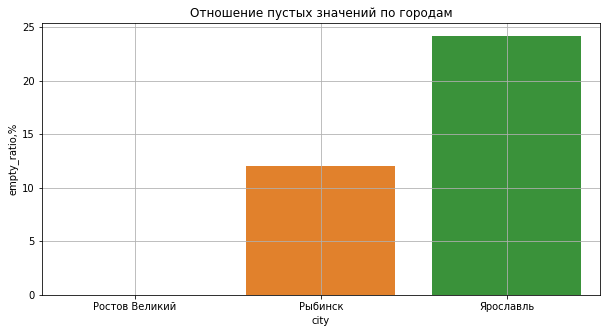

In [15]:
city = [['Ростов Великий', 'Рыбинск', 'Ярославль']]
for i in city:
    empty_ratio = (nan[i].sum()/len(bank[i])*100).reset_index()
    empty_count = nan[i].sum().reset_index()
    
    empty = empty_ratio.merge(empty_count[0], on = empty_count['index'], how = 'left')
    empty.drop('key_0', axis = 1, inplace = True)
    empty.rename(columns = {'index': 'city',
                       '0_x': 'empty_ratio,%',
                       '0_y': 'empty_quantity'}, 
                 inplace = True)
display(empty)

def bar(data,x_values, y_values):
    plt.figure(figsize=(10, 5))
    sns.barplot(data = data,
                x = x_values,
                y = y_values)
    plt.grid()

bar(empty, 'city', 'empty_ratio,%')
plt.title('Отношение пустых значений по городам')

plt.show()

Ситуация с пропусками в столбце  balance выглядит следующим образом:

1) По клиентам из Ярославя 2418 пропусков, что составляет 24,2% от общего числа записей баланса,

2) По Рыбинским клиентам 1199 пропусков, что составляет почти 12% от общего числа записей,

3) В Ростове Великом пропусков в столбце balance не наблюдается.

Наблюдательно, что чем меньше город, тем меньше пропусков в столбце balance. Можно предположить, что в маленьких городах меньше различных банков, в связи с этим, люди хранят свои деньги в банке, который представлен в городе. Так же не стоит забывать про зарплатные продукты, которые может обслуживать банк в городе, в маленьких городах 1 банк может охватить большую часть населения. 

Однако, чем больше город, тем пропусков в столбце balace становиться больше, что хорошо видно на столбчатом графике. С увеличением города, количество самих банков и конкуренция среди них растет, люди могут быть клиентами нескольких банков, пользоваться их продуктами одновременно, но хранят деньги, как правило, в одном банке (сам являюсь клиентом 5 банков, однако деньги на счету храню в одном). В связи с этим, можно считать, что пропуски это не ошибка, а всего лишь отсутствие денег на банковском счете. Поэтому принято решение пропуски заменить на значение 0.

In [16]:
bank['balance'] = bank['balance'].fillna(0) #заменим пропуски на 0

## Исследовательский анализ данных

In [17]:
bank.describe()

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,gender_new,Ростов Великий,Рыбинск,Ярославль
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.545700,0.250900,0.247700,0.501400
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.497932,0.433553,0.431698,0.500023
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,1.000000,0.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000,1.000000


### Изучение средних значений признаков

Посмотрим на средние значения признаков:

In [18]:
bank.mean()

score                  650.528800
age                     38.921800
objects                  5.012800
balance              76485.889288
products                 1.530200
credit_card              0.705500
loyalty                  0.515100
estimated_salary    100090.239881
churn                    0.203700
gender_new               0.545700
Ростов Великий           0.250900
Рыбинск                  0.247700
Ярославль                0.501400
dtype: float64

Посмотрим на средние значения признаков в разрезе уровня оттока клиентов:

In [19]:
bank_mean_churn = (bank
             .groupby('churn')
             .agg('mean')
             .transpose() #перевернем
             .rename(columns = {0:'остался', 1:'ушел'}) #переименуем для удобства восприятия
            )
bank_mean_churn

churn,остался,ушел
score,651.853196,645.351497
age,37.408389,44.837997
objects,5.033279,4.932744
balance,72745.296779,91108.539337
products,1.544267,1.475209
credit_card,0.707146,0.699067
loyalty,0.554565,0.360825
estimated_salary,99738.391772,101465.677531
gender_new,0.572523,0.440844
Ростов Великий,0.212859,0.399607


,city,churn,"churn,%"
0,Ростов Великий,0.324432,32.443204
1,Рыбинск,0.166734,16.673395
2,Ярославль,0.161548,16.154767


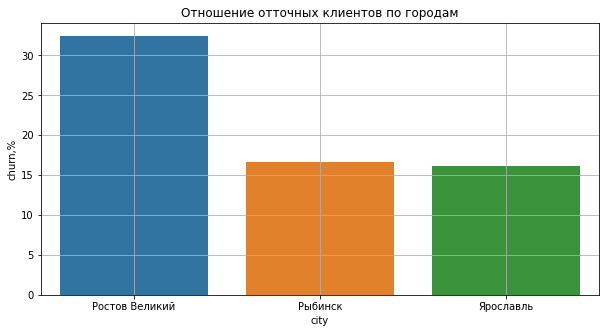

In [20]:
churn_by_city = (bank_original
                 .groupby('city')['churn']
                 .agg('mean').reset_index()
                )
churn_by_city['churn,%'] = churn_by_city['churn']*100
display(churn_by_city)
bar(churn_by_city, 'city', 'churn,%')
plt.title('Отношение отточных клиентов по городам')
plt.show()

1) Средний показатель банковского рейтинга у клиентов, которые остались с банком незначительно выше.

2) Средний возраст клиентов, которые уходят в отток составляет приблизительно 45 лет, средний возраст оставшихся клиентов 37 лет.

3) Средний показатель имущества в обеих группах приблизительно равен и равен 5.

4) У отточников средний показатель счета больше чем у тех, кто остался с банком и составляет 91 108 у.е, против 72 745у.е.

5) Средний показатель пользования продуктами банка у оставшихся клиентов равен 1.54, у отточников - 1.47.

6) Практически 71% оставшихся клиентов обладают кредитной картой, у отточников этот показатель чуть скромнее и составляет 70%.

7) Оставшиеся с банком клиенты более активны, чем  отточные клиенты.

8) Средний показатель зарплаты отточных клиентов составляет 101 465 у.е., у клиентов оставшихся с банком средний показатель по заработной плате немного скромнее и составляет 99 738 у.е.

9) Среди оставшихся клиентов преобладают мужчины, среди отточных клиентов - женщины.

10) Больше всего отточных клиентов в Ростове Великом - 32.4%, в Рыбинске - 16.7% и Ярославле - 16.2%.

11) Половина клиентов проживает в Ярославле - 50%, в Ростов Великий - 25%  и Рыбинске -25%.

## Изучение распределения признаков и поиск аномалий в разрезе уровня оттока клиентов

#### Поиск и изучение аномалий 

Для выявления аномалий выведем ящик с усами по числовым значениям:

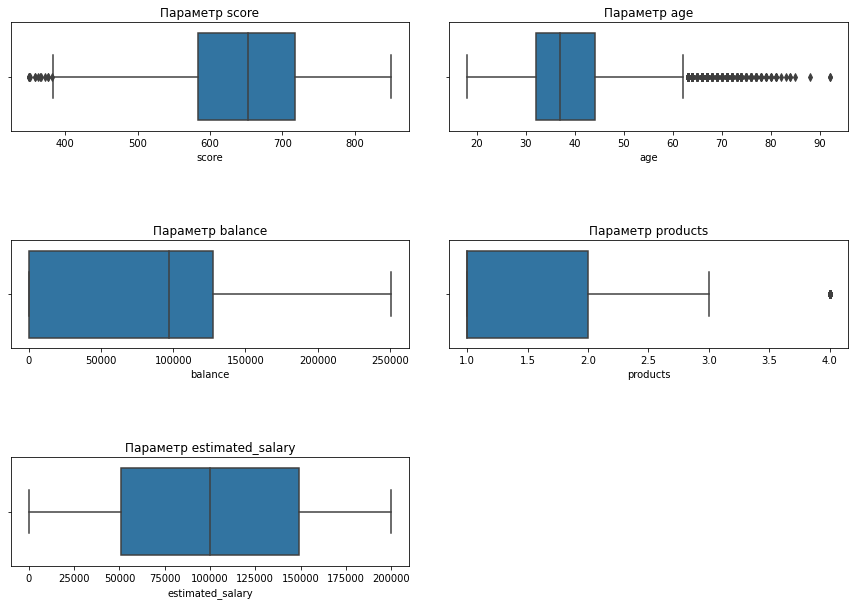

In [21]:
box = ['score', 'age', 'balance', 'products', 'estimated_salary'] #список столбцоы с числовми значениями
plt.figure(figsize = (15,10))
plt.subplots_adjust(wspace=0.1, hspace=1) #регулирование расстояния между субграфиками
for i in enumerate(box):
    plt.subplot(3, 2, i[0]+1)
    sns.boxplot(x = i[1], data = bank)
    plt.title(f'Параметр {i[1]}')

Видно, что аномально высокие или аномально низкие значения есть в параметре score, age и products. Посмотрим на перцентили (1,5,95 и 99):

In [22]:
for percentiles in box:
    print('\033[1m' + 'Параметр', percentiles.upper() + '\033[0m')
    display(f'1 - ый персентиль для параметра {percentiles} равен {np.percentile(bank[percentiles], [1])}')
    display(f'5 - ый персентиль для параметра {percentiles} равен {np.percentile(bank[percentiles], [5])}')
    display(f'95 - ый персентиль для параметра {percentiles} равен {np.percentile(bank[percentiles], [95])}')
    display(f'99 - ый персентиль для параметра {percentiles} равен {np.percentile(bank[percentiles], [99])}')


Параметр SCORE


'1 - ый персентиль для параметра score равен [432.]'

'5 - ый персентиль для параметра score равен [489.]'

'95 - ый персентиль для параметра score равен [812.]'

'99 - ый персентиль для параметра score равен [850.]'

Параметр AGE


'1 - ый персентиль для параметра age равен [21.]'

'5 - ый персентиль для параметра age равен [25.]'

'95 - ый персентиль для параметра age равен [60.]'

'99 - ый персентиль для параметра age равен [72.]'

Параметр BALANCE


'1 - ый персентиль для параметра balance равен [0.]'

'5 - ый персентиль для параметра balance равен [0.]'

'95 - ый персентиль для параметра balance равен [162711.669]'

'99 - ый персентиль для параметра balance равен [185967.9854]'

Параметр PRODUCTS


'1 - ый персентиль для параметра products равен [1.]'

'5 - ый персентиль для параметра products равен [1.]'

'95 - ый персентиль для параметра products равен [2.]'

'99 - ый персентиль для параметра products равен [3.]'

Параметр ESTIMATED_SALARY


'1 - ый персентиль для параметра estimated_salary равен [1842.8253]'

'5 - ый персентиль для параметра estimated_salary равен [9851.8185]'

'95 - ый персентиль для параметра estimated_salary равен [190155.3755]'

'99 - ый персентиль для параметра estimated_salary равен [198069.7345]'

Выбросы решено не выкидывать из изучения и провести анализ вместе с ними.

#### Изучение распределения значений признаков

In [23]:
#список с бинарными признаками
binar_list = ['credit_card', 'loyalty', 'gender_new', 'Ростов Великий', 'Рыбинск', 'Ярославль'] 
no_binar_features = bank.drop(binar_list, axis = 1) #небинарные признаки
binar_features = bank.drop(no_binar_features.columns[0:6], axis = 1) #бинарные признаки

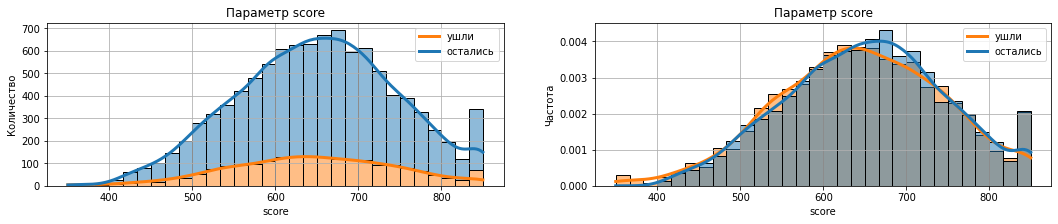

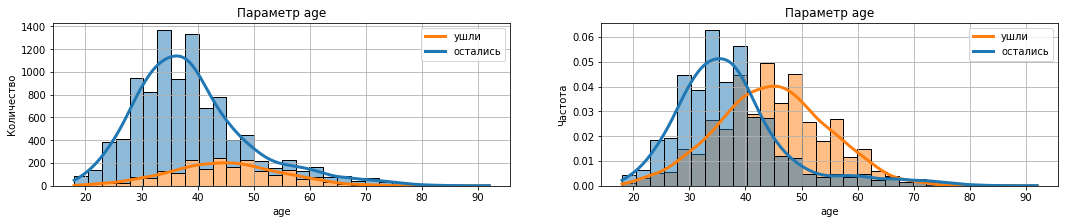

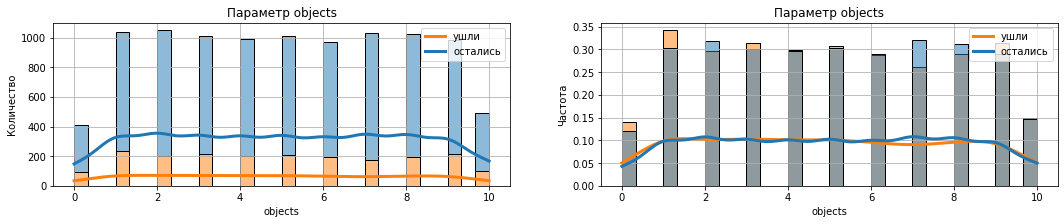

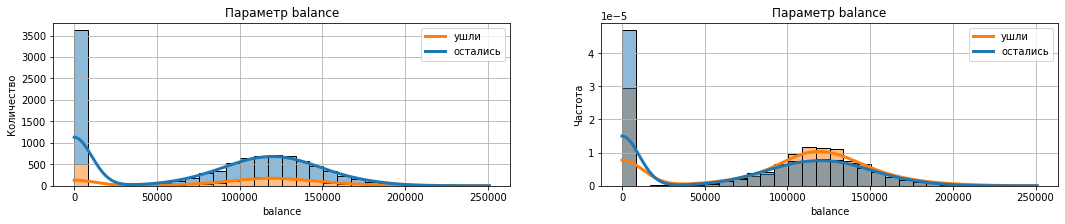

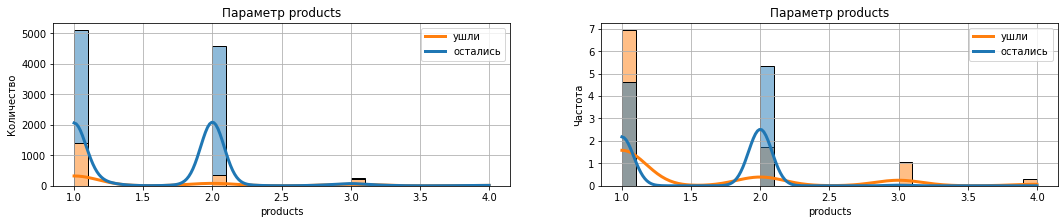

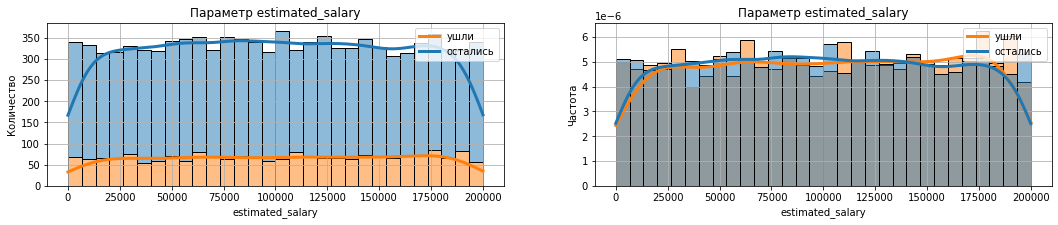

In [24]:
for feature in no_binar_features.drop('churn', axis = 1): #построим распределения для небинарных признаков     
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(18,3))
    
    sns.histplot(data = no_binar_features,
                 x = no_binar_features[feature],
                 hue = 'churn', 
                 kde = True,
                 #stat = 'density',
                 #common_norm = False,
                 multiple = 'stack',
                 line_kws={"lw":3},
                 bins = 30,
                ax = ax1
                )
   
    sns.histplot(data = no_binar_features, #нормализованный
                 x = no_binar_features[feature],
                 hue = 'churn', 
                 kde = True,
                 stat = 'density',
                 common_norm = False,
                 #multiple = 'stack',
                 line_kws={"lw":3},
                 bins = 30,
                ax = ax2
                )
    
    ax1.set_title(f'Параметр {feature}') 
    ax2.set_title(f'Параметр {feature}') 
    ax1.set_ylabel('Количество')
    ax2.set_ylabel('Частота')
    ax1.grid()
    ax2.grid()
    ax1.legend(('ушли', 'остались'), loc='upper right')
    ax2.legend(('ушли', 'остались'), loc='upper right')
    plt.show()

Посмотрим на диапазоны возрастов по оттоку:

In [25]:
sd = pd.DataFrame([bank.query('churn == 0')['age'].describe(), #неотточные
                 bank.query('churn == 1')['age'].describe()]) #отточные

sd.index = ['остались', 'ушли'] #переименуем индексы
sd

,count,mean,std,min,25%,50%,75%,max
остались,7963.0,37.408389,10.125363,18.0,31.0,36.0,41.0,92.0
ушли,2037.0,44.837997,9.761562,18.0,38.0,45.0,51.0,84.0


Из всех выведенных параметров на нормальное распределение претендует только параметр age. 

По выведенным гистограммам можно сказать:

1) Так как гистограма age тех, кто ушел смещена вправо относительно тех кто остался, то можно утверждать, что возраст ушедших больше. У оставшихся клиентов основной диапазон возраста составляет 31-41 лет, у ушедших  - 38-51 лет.

2) Гистограма распределения параметра object образует плато в диапазоне 1-9.

3) Параметр balace обладает большим количеством пустых счетов

4) Больше всего клиенты пользуются 1 или 2 продуктами от банка

5) Распределение параметра estimated_salary образует плато

Выведем графики по бинарным параметрам:

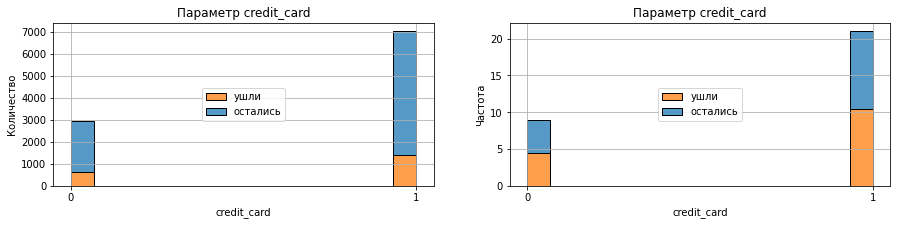

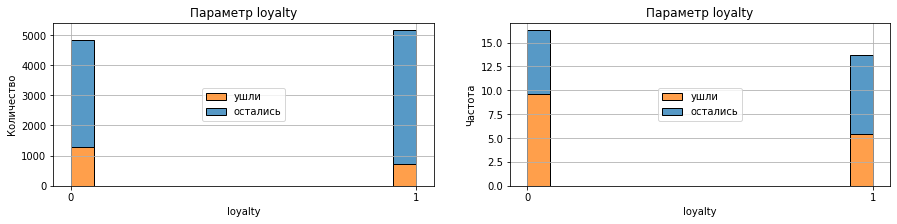

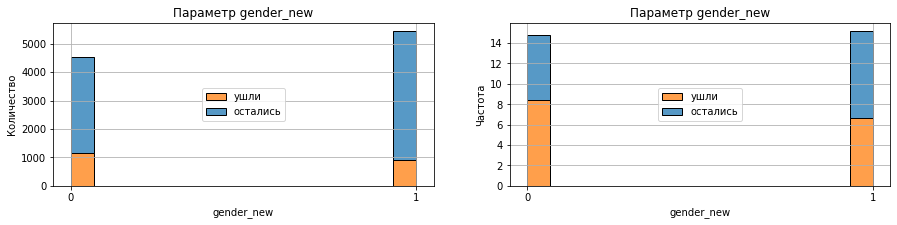

In [26]:
for feature in binar_features.drop(['Ростов Великий', 'Рыбинск', 'Ярославль', 'churn'], axis = 1): #распределения для небинарных признаков
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,3)) 

    
    sns.histplot(data = binar_features,
                 x = binar_features[feature],
                 hue = 'churn', 
                 kde = False,
                 #stat = 'density',
                 #common_norm = False,
                 multiple = 'stack',
                 ax = ax1
                )
   
    sns.histplot(data = binar_features, #нормализованный
                 x = binar_features[feature],
                 hue = 'churn', 
                 kde = False,
                 stat = 'density',
                 common_norm = False,
                 multiple = 'stack',
                 ax = ax2
                )
    
    ax1.set_title(f'Параметр {feature}') 
    ax2.set_title(f'Параметр {feature}') 
    ax1.set_ylabel('Количество')
    ax2.set_ylabel('Частота')
    ax1.set_xticks([0,1])
    ax2.set_xticks([0,1])
    ax1.grid()
    ax2.grid()
    ax1.legend(('ушли', 'остались'), loc='center')
    ax2.legend(('ушли', 'остались'), loc='center')
    plt.show()

###  Матрица корреляции

<AxesSubplot:>

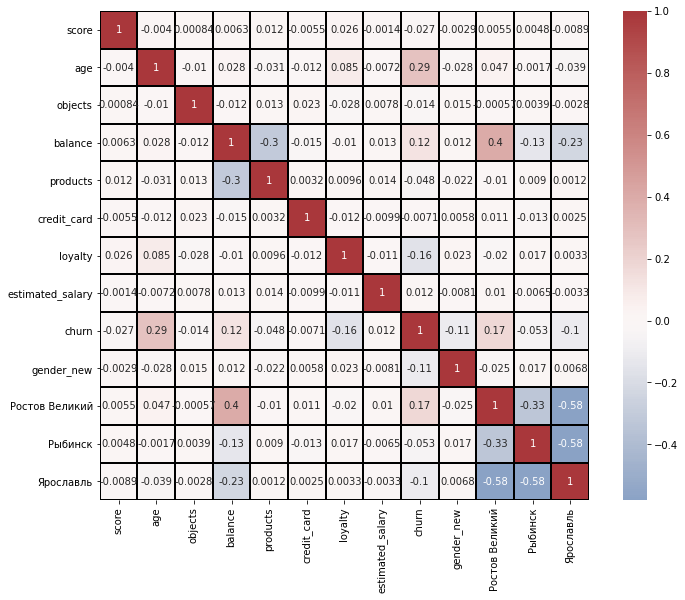

In [27]:
corr_bank = bank.corr() #построим таблицу корреляции

plt.figure(figsize=(12, 9))
sns.heatmap(corr_bank, 
            center= 0, 
            annot = True, 
            square = True, 
            linewidths=1, 
            linecolor='black', 
            cmap= 'vlag'
           )

На отток клиентов сильно влияют такие признаки как возраст (выше мы определили, что чем старше клиент, тем вероятность его ухода больше), баланс - чем больше баланс, тем вероятность ухода клиента больше (определили выше). 

Город Ростов великий обладает сильной положительной корреляцией к балансу и оттоку.

## Сегментация пользователей по количеству потребляемых продуктов


### Сегментация пользователей

Сегментация пользователей будет производится по количеству потребляемых продуктов, а также на основе дополнительных признаков.

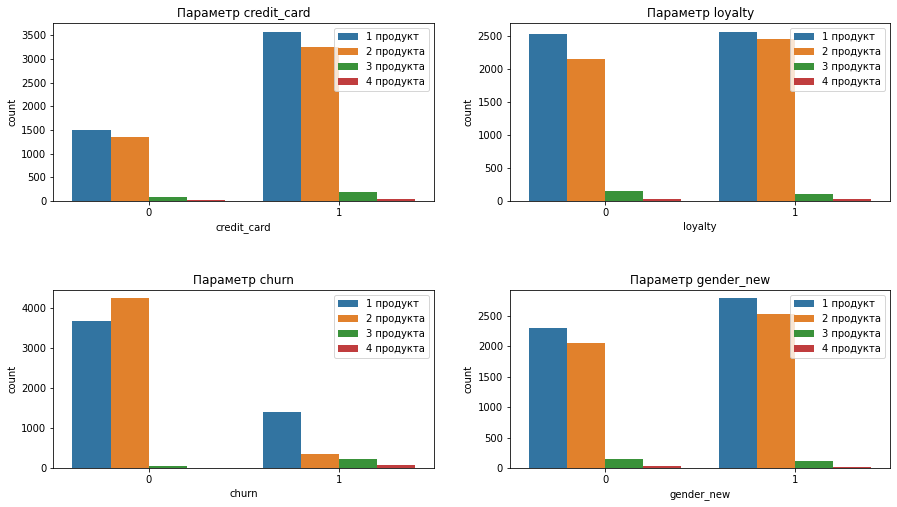

In [28]:
plt.figure(figsize = (15,18))
plt.subplots_adjust(wspace=0.2, hspace=0.5) #регулирование расстояния между субграфиками
for feature in enumerate(binar_features.drop(['Ростов Великий', 'Рыбинск', 'Ярославль'], axis = 1)): 
    plt.subplot(4, 2, feature[0]+1)
    sns.countplot(data = bank, #нормализованный
                 x = feature[1],
                 hue = 'products'
                )
    plt.legend(('1 продукт', '2 продукта', '3 продукта', '4 продукта'), loc='upper right')
    plt.title(f'Параметр {feature[1]}')


Анализируя графики, можно сказать:

1) Больше всего клиенты банка предпочитают пользоваться 1 или 2 продуктами банка, реже 3 продуктами и совсем редко 4. 

2) Среди обладателей кредитных карт больше всего пользующихся 1-2 продуктами банка, что говорит о том, что кредитная карта входит в признак "продукт".

3) Если клиент пользуется 2 продуктами банка, то вероятность его оттока невелика, если клиент пользуется 1 продуктом от банка, то вероятность оттока увеличивается. Больше всего в отток уходят пользователи 3-4 продуктов от банка.

In [29]:
bank.groupby('products').agg('mean').T #выведем среднее по продуктам

products,1,2,3,4
score,649.120968,652.188671,648.105263,653.583333
age,39.673092,37.753595,43.195489,45.683333
objects,4.974626,5.051852,5.003759,5.300000
balance,98551.870614,51879.145813,75458.328195,93733.135000
credit_card,0.703777,0.707190,0.714286,0.683333
loyalty,0.504131,0.532898,0.424812,0.483333
estimated_salary,99487.256851,100452.012821,104318.130564,104763.723333
churn,0.277144,0.075817,0.827068,1.000000
gender_new,0.548387,0.551198,0.439850,0.366667
Ростов Великий,0.265342,0.226580,0.360902,0.400000


В таблице средних показателей параметров по продуктам видно:

1) Банковский рейтинг ближе всего у клиентов, пользующихся 1,3 (649 и 648) и 2,4 (652 и 654) продуктами.

2) Средний возраст клиентов пользующихся 1 или 2 продуктами меньше (40 и 38 соответствено), чем у клиентов обладающих 3 или 4 продуктами (43 и 46 соответсвенно).

3) Среднее количество имущества во всех группах примерно одинаковое и составляет 5 объектов.

4) Самый маленький средний баланс находится у клиентов с 2 продуктами от банка и составляет 51 879 у.е.

Клиенты с 3-мя продуктами обладают средним балансом на счете 75 458 у.е

У клиентов использующих 4 продукта средний баланс на счету составляет 93 733 у.е

Наибольший средний баланс у группы, которая пользуется 1 продуктом банка и составляет 98 551 у.е.

5) Кредитными картами обладают во всех группах от от 68 до 71 % клиентов.

6) Наименее активная категория клиентов пользуется 3- мя продуктами о банка (42% клиентов активные). Наиболее активные клиенты пользуются двумя продуктами от банка (53% активные).

7) Наибольшая средняя заработная плата у клиентов, которые используют 3 и 4 банковских продукта (104 318 у.е. и 104 763 у.е.).
Наименьшая средняя заработная плата замечена у клиентов использующих 1 банковский продукт и составляет 99 487 у.е.
Средняя зарплата у людей, которые пользуются 2 продуктами близка к клиентам с 1 продуктом и составляет 100 452 у.е.

8) В группах где клиенты пользуются 3 и 4 продуктами от банка преобладает женская категория (56% и 63% соответственно), в группах с 1 и 2 продуктами преобладают мужчины (по 55%).




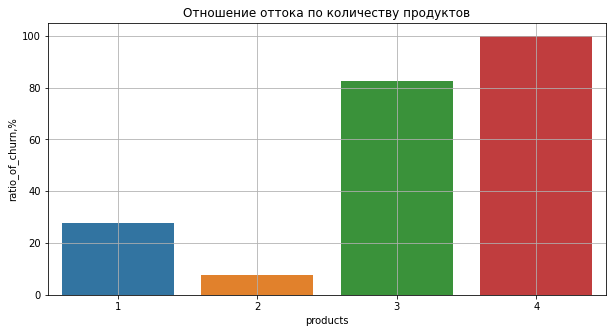

In [30]:
#посчитаем отношение отточных клиентов по продуктам
products_by_churn = (
    (
        bank.groupby('products')['churn'].sum()
        /
        bank['products'].value_counts()*100
    )
    .reset_index()
    .rename(columns = {0:'ratio_of_churn,%'})
)

# выведем график
bar(products_by_churn, 'products', 'ratio_of_churn,%')
plt.title('Отношение оттока по количеству продуктов')
plt.show()

Рассмотрим отток по количеству банковских продуктов, которыми пользуется клиент:

1) *Один продукт.*  Отток среди клиентов, которые пользуются 1 продуктом от банка составляет 27,7%, что является вторым показателем по удержанию клиентов

2) *Два продукта*. Наименьший отток наблюдается среди клиентов данной группы. Отток тех, кто пользуется двумя продуктами от банка составляет 7,6%.

3) *Три продукта.* Клиенты, которые пользуются 3 продуктами уходят из банка в 83% случаев, что безусловно много.

4) *Четыре продукта.* Антилидер по удержанию клиентов банка.  Отток людей, использовавших 4 продута составляет 100%.

**Вывод:**

Анализируя таблицу со средними показателями и график уровня оттока клиентов по группам количества используемых продуктов банка видно следующие яркие признаки:

1) У клиентов с 3 или 4 банковскими продуктами больше средний возраст (43 и 46 соответсвено), клиенты с 1 или 2 продуктами моложе, средний возраст составляет 40 и 38 лет соответственно.

2) Наибольшая средняя заработная плата у клиентов, которые используют 3 или 4 банковских продукта

3) В группах где клиенты пользуются 3 или 4 продуктами от банка преобладает женская категория (56% и 63% соответственно)

4) Клиенты использующие 3 или 4 банковских продукта чаще всего уходят в отток (83%  и 100%)

В связи  с выше сказанным принято решение разделить клиентов банка на 3 сегмента: 

*Первый сегмент* **(1)**: Клиенты использующие 1 банковский продукт.

*Второй сегмент* **(2)**: Клиенты использующие 2 банковских продукта.

*Третий сегмент* **(3)**: Клиенты использующие 3 или 4 банковских продукта.

### Анализ по сегментам

In [31]:
def segments(products):
    if products == 1:
        return 1
    if products == 2:
        return 2
    if products == 3 or products == 4:
        return 3
bank['segments'] = bank['products'].apply(segments)

In [32]:
bank['segments'].value_counts()

1    5084
2    4590
3     326
Name: segments, dtype: int64

In [33]:
#посомтрим отношение клиентов по сегментам относительно всех  клиентов банка
pd.DataFrame(bank['segments'].value_counts()/bank['score'].count()*100)

,segments
1,50.84
2,45.90
3,3.26


Категория 3 самая малочисленная, но самая отточная, на нее обязательно следует обратить внимание.

In [34]:
bank.groupby('segments').agg('mean').T #выведем среднее по сегментам

segments,1,2,3
score,649.120968,652.188671,649.113497
age,39.673092,37.753595,43.653374
objects,4.974626,5.051852,5.058282
balance,98551.870614,51879.145813,78821.789571
products,1.000000,2.000000,3.184049
credit_card,0.703777,0.707190,0.708589
loyalty,0.504131,0.532898,0.435583
estimated_salary,99487.256851,100452.012821,104400.141503
churn,0.277144,0.075817,0.858896
gender_new,0.548387,0.551198,0.426380


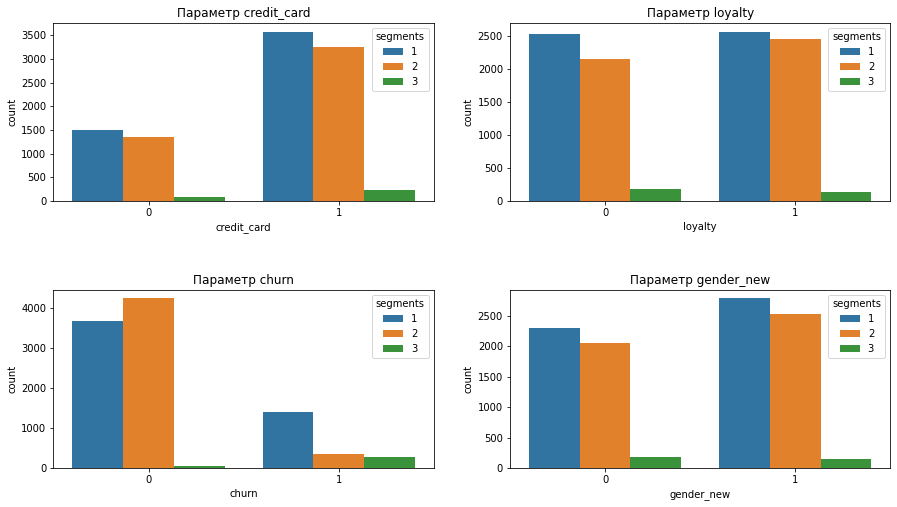

In [35]:
plt.figure(figsize = (15,18))
plt.subplots_adjust(wspace=0.2, hspace=0.5) #регулирование расстояния между субграфиками
for feature in enumerate(binar_features.drop(['Ростов Великий', 'Рыбинск', 'Ярославль'], axis = 1)): 
    plt.subplot(4, 2, feature[0]+1)
    sns.countplot(data = bank, #нормализованный
                 x = feature[1],
                 hue = 'segments'
                )
    plt.title(f'Параметр {feature[1]}')

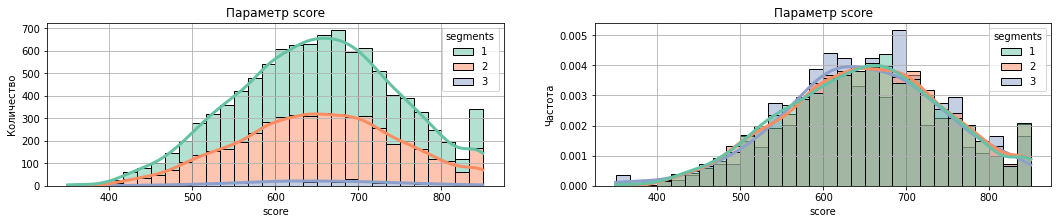

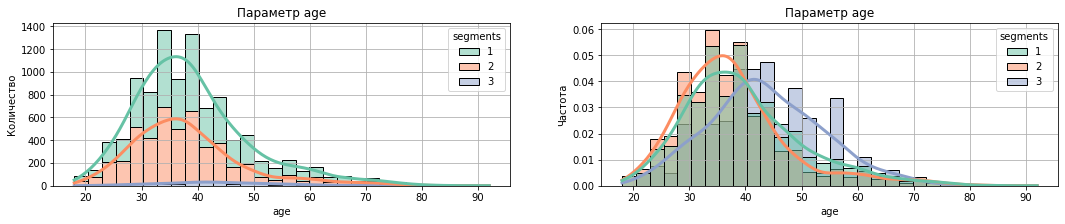

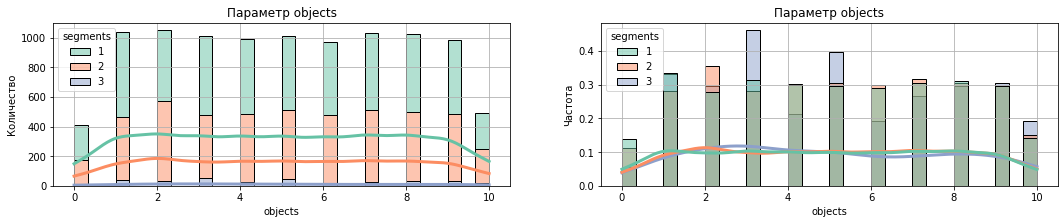

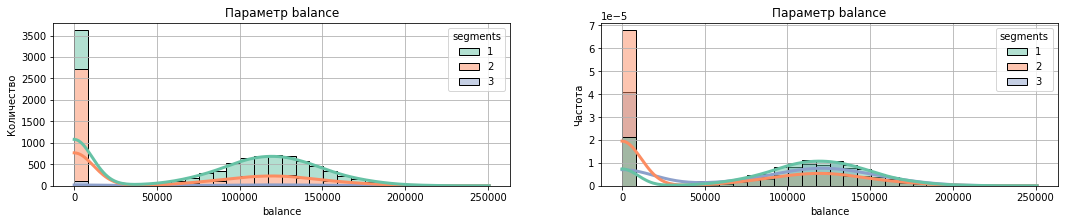

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


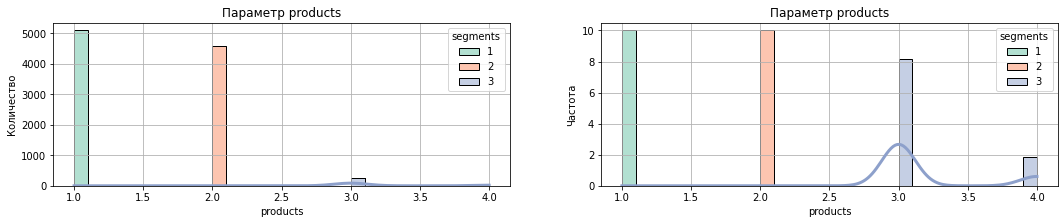

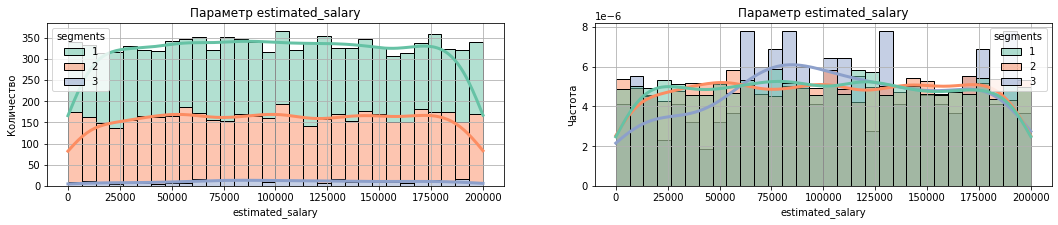

In [36]:
for feature in no_binar_features.drop('churn', axis = 1): #построим распределения для небинарных признаков     
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(18,3))
    
    sns.histplot(data = bank,
                 x = bank[feature],
                 hue = 'segments', 
                 kde = True,
                 #stat = 'density',
                 #common_norm = False,
                 multiple = 'stack',
                 line_kws={"lw":3},
                 bins = 30,
                 palette = 'Set2',
                ax = ax1
                )
   
    sns.histplot(data = bank, #нормализованный
                 x = bank[feature],
                 hue = 'segments', 
                 kde = True,
                 stat = 'density',
                 common_norm = False,
                 #multiple = 'stack',
                 line_kws={"lw":3},
                 bins = 30,
                 palette = 'Set2',
                ax = ax2
                )
    
    ax1.set_title(f'Параметр {feature}') 
    ax2.set_title(f'Параметр {feature}') 
    ax1.set_ylabel('Количество')
    ax2.set_ylabel('Частота')
    ax1.grid()
    ax2.grid()
    plt.show()

## Кластеризация

Для проверки сегментации клиентов вручную проведем кластеризацию и посмотрим сколько выделится кластеров и как разделятся значения.

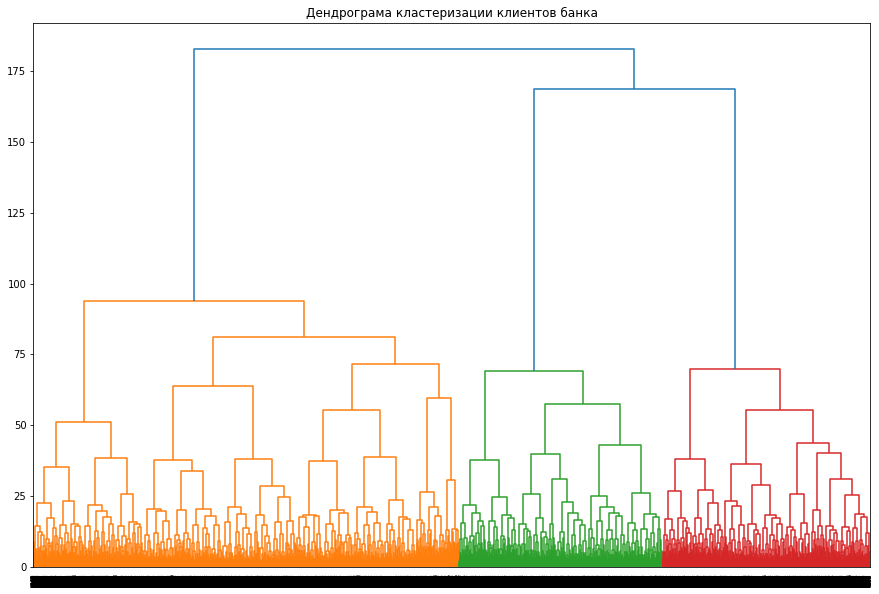

In [37]:
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(bank.drop(['churn', 'segments'], axis = 1))

#строим матрцу
linked = linkage(x_sc, method = 'ward') 
#выводим дендограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограма кластеризации клиентов банка')
plt.show() 

In [38]:
# задаём модель k_means с числом кластеров 3 и фиксируем значение random_state
km = KMeans(n_clusters=3, random_state=0)

# прогнозируем кластеры для наблюдений 
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
bank_with_cluster = bank
bank_with_cluster['cluster'] = labels #добавим столбец с кластерами

In [39]:
bank_with_cluster.groupby('cluster').agg('mean').T #выведем среднее по продуктам

cluster,0,1,2
score,649.668329,651.333872,651.453567
age,38.511767,38.890997,39.771622
objects,5.004587,5.032297,5.009964
balance,62092.636516,61818.147763,119730.116134
products,1.530913,1.539362,1.519729
credit_card,0.706621,0.694792,0.713830
loyalty,0.516753,0.529673,0.497409
estimated_salary,99899.180814,99440.572281,101113.435102
churn,0.161548,0.166734,0.324432
gender_new,0.549063,0.560355,0.524512


Итак, модель так же выделила 3 кластера, однако в разбиение она сделала упор на города. Поэтому будем опираться на сегментацию сделанную вручную.

## Проверка статистической гипотезы

В данном разделе будем проверять 2 статистических гипотезы:

1) Доходы между клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним - различаются.

2) Кредитный рейтинг между категориями различается

### Доходы между клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним -  различаются.

Выделим два отдельных датасета с доходами клиентов использующих 1 и 2 продукта от банка.

In [40]:
one_product = bank.query('products == 1')['estimated_salary']
two_products = bank.query('products == 2')['estimated_salary']

Перед тем как проверять наши гипотезы, определимся с тестом, который будем использовать: Стьюдента или Мана-Уитни. Для этого посмотрим на распределение зарплат по количеству продуктов.

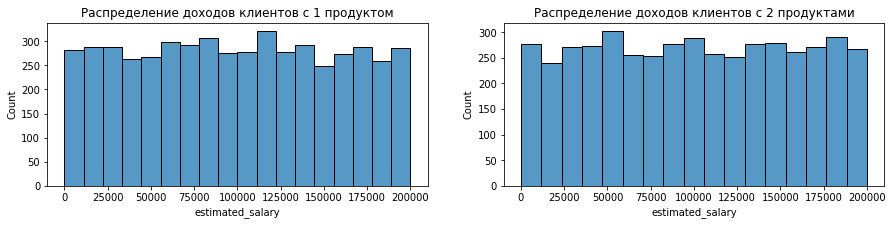

In [41]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,3))
sns.histplot(one_product, ax=ax1)
sns.histplot(two_products, ax=ax2)
ax1.set_title('Распределение доходов клиентов с 1 продуктом') 
ax2.set_title('Распределение доходов клиентов с 2 продуктами') 
plt.show()

Невооруженным глазом видно, что распределения не являются нормальными, но чтобы точно убедить в этом проведем тест методом Шапиро-Уилка. Для начала выдвинем нулевую и альтернативную гипотезу.

***Нулевая гипотеза H0***: Значения заработных плат клиентов, использующих 1 или 2 банковских продукта распределены нормально

***Альтернативная гипотеза H1***: Значения заработных плат клиентов, использующих 1 или 2 банковских продукта распределены не нормально

In [42]:
alpha = 0.05  # критический уровень статистической значимости

results1 = st.shapiro(one_product)
results2 = st.shapiro(two_products)

p_value1 = results1[1]  
p_value2 = results2[1] 

print('\033[1m' + 'Распределение доходов клиентов с 1 продуктом' + '\033[0m')
print('p-значение: ', p_value1)

if p_value1 < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 
    
print('\033[1m' + 'Распределение доходов клиентов с 2 продуктами' + '\033[0m')    
print('p-значение: ', p_value2)

if p_value2 < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

Распределение доходов клиентов с 1 продуктом
p-значение:  3.017243029368968e-36
Отвергаем нулевую гипотезу: распределение не нормально
Распределение доходов клиентов с 2 продуктами
p-значение:  2.1702207154579243e-35
Отвергаем нулевую гипотезу: распределение не нормально


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


В связи с не нормальным распределением значений заработных плат, для сравнения выборок у использовать непараметрический тест Мана-Уитни. Для начала выделим нулевую и альтернативную гипотезу:



***Нулевая гипотеза H0***: Доходы между клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним - не различаются.

***Альтернативная гипотеза H1***: Доходы между клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним - различаются.

Критический уровень статистической значимости alpha принимаем равным 0,05 или 5%

In [43]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(one_product, two_products)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: доходы клиентов, которые пользуются двумя продуктами банка', 
          'и теми, которые пользуются одним - различаются')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: доходы клиентов, которые пользуются двумя продуктами банка', 
          'и теми, которые пользуются одним - не различаются'
    ) 

p-значение:  0.4079566651927651
Не получилось отвергнуть нулевую гипотезу: доходы клиентов, которые пользуются двумя продуктами банка и теми, которые пользуются одним - не различаются


### Кредитный рейтинг между категорями различается

Перед тем как выдвигать и тестировать гипотезы выделим три отдельных датасета банковского рейтинга по сегментам:

In [44]:
first = bank.query('segments == 1') ['score']
second = bank.query('segments == 2') ['score']
third = bank.query('segments == 3') ['score']

Для выбора теста, который бедем использовать, посмотрим на распределения:

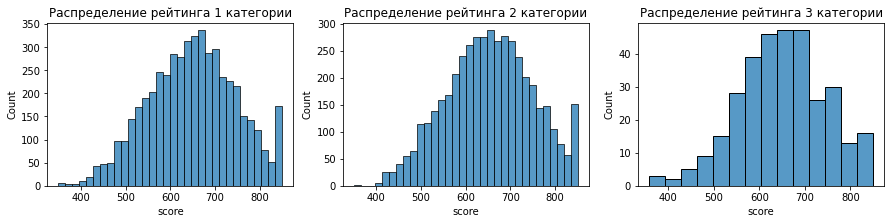

In [45]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(15,3))
sns.histplot(first, ax=ax1)
sns.histplot(second, ax=ax2)
sns.histplot(third, ax=ax3)
ax1.set_title('Распределение рейтинга 1 категории') 
ax2.set_title('Распределение рейтинга 2 категории') 
ax3.set_title('Распределение рейтинга 3 категории') 
plt.show()

Проверим распределения тестом Шапиро-Уилка.

***Нулевая гипотеза H0***: Банковский рейтинг между категориями распределен нормально.

***Альтернативная гипотеза H1***: Банковский рейтинг между категориями не нормально.

Критический уровень статистической значимости alpha принмаем равным 0,05 или 5%

In [46]:
alpha = 0.05  # критический уровень статистической значимости

results1 = st.shapiro(first)
results2 = st.shapiro(second)
results3 = st.shapiro(third)

p_value1 = results1[1]  
p_value2 = results2[1] 
p_value3 = results3[1] 

print('\033[1m' + 'Распределение рейтинга 1 категории' + '\033[0m')
print('p-значение: ', p_value1)

if p_value1 < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 
    
print('\033[1m' + 'Распределение рейтинга 2 категории' + '\033[0m')    
print('p-значение: ', p_value2)

if p_value2 < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 
    
print('\033[1m' + 'Распределение рейтинга 3 категории' + '\033[0m')    
print('p-значение: ', p_value3)

if p_value2 < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

Распределение рейтинга 1 категории
p-значение:  1.1799972620112759e-13
Отвергаем нулевую гипотезу: распределение не нормально
Распределение рейтинга 2 категории
p-значение:  3.5868209850810004e-14
Отвергаем нулевую гипотезу: распределение не нормально
Распределение рейтинга 3 категории
p-значение:  0.13648726046085358
Отвергаем нулевую гипотезу: распределение не нормально


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Так как рейтинг распределен ненормально будем использовать непараметрический тест Мана-Уитни. Для начала выделим нулевую и альтернативную гипотезу:


***Нулевая гипотеза H0***: Банковский рейтинг между категориями - не различается.

***Альтернативная гипотеза H1***: Банковский рейтинг между категориями - различается.

Критический уровень статистической значимости alpha принимаем равным 0,05 или 5%

In [47]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results1 = st.mannwhitneyu(
    first, 
    second)

results2 = st.mannwhitneyu(
    first, 
    third )

results3 = st.mannwhitneyu(
    second, 
    third)

bonferroni_alpha = alpha / 3  # снизим вероятность ошибки первого рода

print('\033[1m' + 'Гипотеза о равенстве кредитного рейтинга 1 и 2 сегмента' + '\033[0m')
print('p-значение:', results1.pvalue)

if results.pvalue < bonferroni_alpha:
    print("Отвергаем нулевую гипотезу - кредитный рейтинг разный")
else:
    print("Не получилось отвергнуть нулевую гипотезу - кредитный рейтинг одинаковый")

print('\033[1m' + 'Гипотеза о равенстве кредитного рейтинга 1 и 3 сегмента' + '\033[0m')
print('p-значение:', results2.pvalue)

if results.pvalue < bonferroni_alpha:
    print("Отвергаем нулевую гипотезу - кредитный рейтинг разный")
else:
    print("Не получилось отвергнуть нулевую гипотезу - кредитный рейтинг одинаковый")

print('\033[1m' + 'Гипотеза о равенстве кредитного рейтинга 2 и 3 сегмента' + '\033[0m')
print('p-значение:', results3.pvalue)

if results.pvalue < bonferroni_alpha:
    print("Отвергаем нулевую гипотезу - кредитный рейтинг разный")
else:
    print("Не получилось отвергнуть нулевую гипотезу - кредитный рейтинг одинаковый")

Гипотеза о равенстве кредитного рейтинга 1 и 2 сегмента
p-значение: 0.15729739033138807
Не получилось отвергнуть нулевую гипотезу - кредитный рейтинг одинаковый
Гипотеза о равенстве кредитного рейтинга 1 и 3 сегмента
p-значение: 0.961940362629772
Не получилось отвергнуть нулевую гипотезу - кредитный рейтинг одинаковый
Гипотеза о равенстве кредитного рейтинга 2 и 3 сегмента
p-значение: 0.6384908383653077
Не получилось отвергнуть нулевую гипотезу - кредитный рейтинг одинаковый


## Выводы и рекоммендации

**Выводы**
На основе проведенного исследования и кластеризации делаем следующие выводы:

1) Половина клиентов проживает в Ярославле - 50%, в Ростов Великий - 25% и Рыбинске -25%.

2) В Ярославе 24,2% пустых счетов, в Рыбинске - 12% и Ростове Великом 0%. Заметна корреляция между количеством населения города и количеством пустых счетов. Чем больше город, тем пустых счетов больше. Предположительно это связано с конкуренцией в банковской сфере. В больших городах люди открывают счета в нескольких банках и держат деньги только в одном, в то время как в маленьких городах количество банков в разы меньше, поэтому конкуренции меньше и открывая счет в банке в маленьком городе велика вероятность, что клиент будет хранить деньги только в нем.

3) Больше всего отточных клиентов в Ростове Великом - 32.4%, в Рыбинске - 16.7% и Ярославле - 16.2%

4) Яркие средние значения признаков отточных клиентов:

- Отточные клиенты менее активны. Средняя активность составляет 36%.

- Средний возраст клиентов, которые уходят в отток составляет приблизительно 45 лет, средний возраст оставшихся клиентов 37 лет. Чем больше возраст, тем вероятность ухода клиента больше.

- У отточников средний показатель счета больше чем у тех, кто остался с банком и составляет 91 108 у.е, против 72 745у.е.

- Средний показатель зарплаты отточных клиентов составляет 101 465 у.е., у клиентов оставшихся с банком средний показатель по заработной плате немного скромнее и составляет 99 738 у.е.
 
5) Яркие признаки на основе количества используемых банковских продуктов:

- Больше всего клиенты банка предпочитают пользоваться 1 или 2 продуктами банка, реже 3 продуктами и совсем редко 4.

- Если клиент пользуется 2 продуктами банка, то вероятность его оттока невелика, если клиент пользуется 1 продуктом от банка, то вероятность оттока увеличивается. Больше всего в отток уходят пользователи 3-4 продуктов от банка.

- Средний возраст клиентов, пользующихся 1 или 2 продуктами меньше (40 и 38 соответственно), чем у клиентов обладающих 3 или 4 продуктами (43 и 46 соответственно).
 
- У клиентов с 3 или 4 банковскими продуктами больше средний возраст (43 и 46 соответственно), клиенты с 1 или 2 продуктами моложе, средний возраст составляет 40 и 38 лет соответственно.

- Наибольшая средняя заработная плата у клиентов, которые используют 3 или 4 банковских продукта

- В группах где клиенты пользуются 3 или 4 продуктами от банка преобладает женская категория (56% и 63% соответственно)

- Клиенты, использующие 3 или 4 банковских продукта чаще всего уходят в отток (83% и 100%)

6) На основе количества банковских продуктов, которые использует клиент и дополнительных параметров, изложенных выше была проведена сегментация клиентов. Выделено 3 сегмента:
 
*Первый сегмент (1)*: Клиенты использующие 1 банковский продукт.

*Второй сегмент (2)*: Клиенты использующие 2 банковских продукта.

*Третий сегмент (3)*: Клиенты использующие 3 или 4 банковских продукта.

7) Отношение клиентов по сегментам к общему количеству: 1 сегмент - 50,8%, 2 сегмент - 45,9%, 3 сегмент - 3,3%.

**Рекомендации**

1) Следует увеличить вовлеченность клиентов. Например, проводить промоакции, мотивировать совершать больше финансовых действий со своим счетом (например, обладатели кредитных или дебетовых карт после преодоления шага по тратам получают бонусы, можно сделать эту систему ранговой, чем больше потратил - тем приз или бонусы привлекательнее, так же система кэшбека заставит людей активнее пользоваться картами)

2) Клиенты, которые используют 3 или 4 продукта и обладают наибольшей средней заработной платой больше уходят. Рекомендуется быть более лояльными к таким клиентам. Например, чем больше человек потребляет банковских продуктов, тем меньше комиссия на услуги банка. 

3) Мотивировать клиентов держать деньги на счету привлекательными процентными ставками. Так как это довольно затратное предложение, то мы можем предложить такой момент 3 сегменту. Сегмент 3 пользуется большим количеством продуктов от банка (больше всех приносит денег банку за счет комиссий с операциям, кредитных продуктов и т.д), обладает самой высокой зарплатой из всех сегментов, однако отток большой. В связи с этим, третий сегмент подходит для такой акции.  

## Презентация

https://disk.yandex.ru/i/UePygqqo37BSNw